In [73]:
!git clone https://github.com/Iconic-Aman/Potato-Disease

fatal: destination path 'Potato-Disease' already exists and is not an empty directory.


In [74]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models,losses
import matplotlib.pyplot as plt
import numpy as np

In [75]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [76]:
dataset = tf.keras.utils.image_dataset_from_directory(
    'Potato-Disease/villagepotato',
     shuffle=True,
     image_size=(IMAGE_SIZE, IMAGE_SIZE),
     batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [77]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [78]:
for image, label in dataset.take(1):
    print(label)
    print(label.numpy())
    print(image.shape)
    print(image[0].shape)

tf.Tensor([1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1], shape=(32,), dtype=int32)
[1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1]
(32, 256, 256, 3)
(256, 256, 3)


In [79]:
# plt.figure(figsize=(10,10))
# for image,label in dataset.take(1):
#     for i in range(12):
#         plt.subplot(3,4,i+1)
#         plt.imshow(image[i].numpy().astype('uint8'))
#         # print(label.numpy())
#         plt.axis('off')
#         plt.title(class_name[label[i].numpy()])

80% => TRAINING
20% => (10% VALIDATION, 10% TEST)

In [80]:
train_size = 0.8
len(dataset)*train_size
train_ds = dataset.take(54)
test_ds = dataset.skip(54)
len(train_ds), len(test_ds)

(54, 14)

In [81]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [82]:
val_ds = test_ds.take(6)
test_ds = test_ds.skip(6)
len(val_ds), len(test_ds)

(6, 8)

In [83]:
def get_dataset_partitions_df(ds, train_split = 0.8, test_split=0.1, valid_split=0.1, shuffle=True, shuffle_size=2000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12 )
    train_size = int(train_split*ds_size)
    valid_size = int(valid_split*ds_size)

    train_ds = dataset.take(train_size)
    test_ds = dataset.skip(train_size).skip(valid_size)
    valid_ds = dataset.skip(valid_size).take(valid_size)
    return train_ds, valid_ds, test_ds

In [84]:
train_ds, valid_ds, test_ds = get_dataset_partitions_df(dataset)

In [85]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

resize and rescale the image

In [86]:
resize_rescale = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1/255)
])

In [87]:
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

#### Model training

In [88]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
models = tf.keras.models.Sequential([
    resize_rescale,
    data_augumentation,
    tf.keras.layers.Conv2D(32,3,activation='relu', input_shape = input_shape ),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,3, activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, 3,activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,3, activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, 3,activation = 'relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax'),
])
models.build(input_shape=input_shape)

In [89]:
models.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_10 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                

#### model compile

In [90]:
models.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

#### model fit

In [ ]:
history = models.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=valid_ds
)

#### model evaluation

In [92]:
scores = models.evaluate(test_ds)

8/8 [==============================] - 2s 63ms/step - loss: 0.0167 - accuracy: 0.9914


In [94]:
scores

[0.01671830378472805, 0.9913793206214905]

In [99]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [101]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [112]:
history.history['accuracy'][-4:]

[0.9901620149612427,
 0.9878472089767456,
 0.9918981194496155,
 0.9849537014961243]

In [118]:
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']


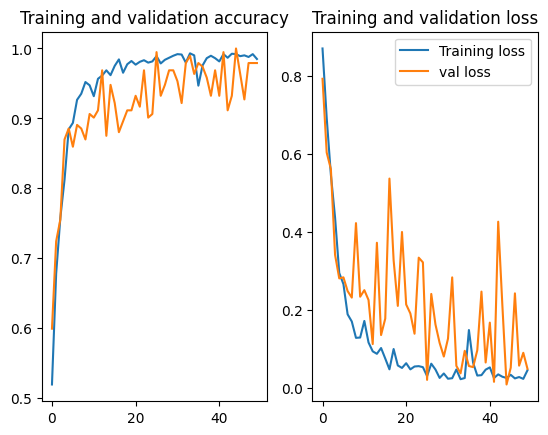

In [135]:
# plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), accuracy, label = 'Training accuracy')
plt.plot(range(EPOCHS), val_accuracy, label = 'val accuracy')
plt.title('Training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'val loss')
plt.title('Training and validation loss')
plt.legend() # it will automatically manipulate where to show the label in graph..


plt.show()

In [206]:
for image_batch , label_batch in test_ds.take(1):
  pred_label = models.predict(image_batch)


1/1 [==============================] - 0s 51ms/step


#### make a func which gives accuracy on the basis of actual output and pred output

In [254]:
def predict(models, images):
  img_arr = tf.keras.preprocessing.image.img_to_array(image[0].numpy())
  img_arr= tf.expand_dims(img_arr, 0)  #create a batch

  pred = models.predict(img_arr)
  predicted_class= class_name[np.argmax(pred_label[0])]
  accuracy = round(100* (np.max(pred[0])),2)
  return predicted_class, accuracy

1/1 [==============================] - 0s 21ms/step


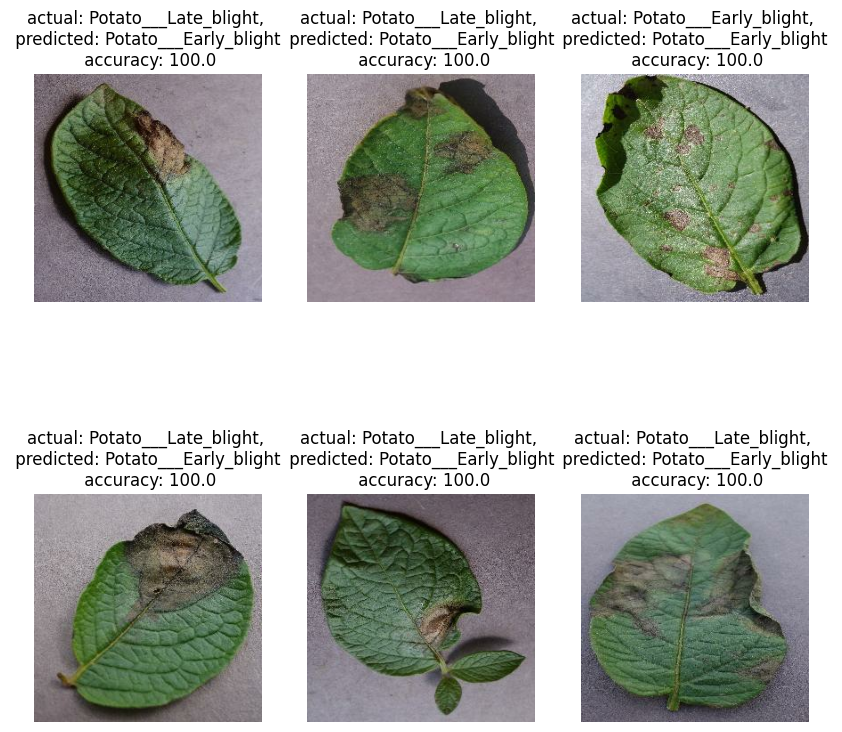

In [255]:
plt.figure(figsize=(10,10))
for image, label in test_ds.take(1):
  for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    pred, acc = predict(models, image[i])
    actual_class = class_name[label[i]]
    plt.title(f"actual: {actual_class}, \n predicted: {pred } \n accuracy: {acc}")
    plt.axis('off')



In [257]:
model_version = 1
models.save(f'models/{model_version}')